# IMDB project: predicting movies scores
### by Javier Alonso

This Jupyter Notebook is part of "My IMDB project" and tries to predict the rates of the movies in IMDB, based on the database published by IMDB

The database was downloaded from IMDB on 2020/05/25 but some days after they changed all the system for retrieving the data, so I won´t be able to upgrade easily the project with new data.

In this case we will try to predict the rates in movies that are in the top % voted movies, because having more votes means a more efficient average rating, as statistics always works better with higher population

The results have been posted in my [blog](xxxx)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning Algorithm](#MLA)<br>
3.a.-[Data preparation](#Data_preparation)<br>
3.b.-[Algorithm Selection](#Alg_Selection)<br>


## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_rand
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_randInt
from scipy.stats import uniform as sp_random

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the precleaned dataset for the EDA

In [2]:
df_movies = pd.read_csv('IMDB_clean_movies.csv')
df_movies.shape

(221748, 12)

A view of the dataframe

In [3]:
df_movies.head(5)

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

First thing we do a copy of my dataframe


In [4]:
movies = df_movies.copy()

In [5]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


#### Keeping top voted movies

For the prediction we will keep only the 5% top voted movies. Let´s see if these can be predicted better than in the first case of the project

In [16]:
movies['numVotes'].describe(percentiles=[0.5,0.9,0.95])

count    2.217480e+05
mean     3.667128e+03
std      3.315393e+04
min      5.000000e+00
50%      5.600000e+01
90%      1.791000e+03
95%      6.293000e+03
max      2.242140e+06
Name: numVotes, dtype: float64

In [17]:
len(movies)

221748

In [18]:
movies = movies[movies.numVotes>6293]

In [19]:
len(movies)

11086

So we will try to predict the rates in 11.086 movies that are the top 5% most voted movies.

#### Incorrect datatypes

Decade should be string. We change the datatype

In [20]:
movies.decade = movies.decade.astype(str)

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 263 to 221712
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  int64  
 3   Minutes        11086 non-null  int64  
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  int64  
 7   decade         11086 non-null  object 
 8   director       11086 non-null  object 
 9   actors         11086 non-null  object 
 10  actress        11085 non-null  object 
 11  writers        11086 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 1.1+ MB


#### Deleting columns

**Director, actors, actress and writers column** as we will get them from other dataframe

In [22]:
movies = movies.drop(['director'], axis=1)
movies = movies.drop(['actors'], axis=1)
movies = movies.drop(['actress'], axis=1)
movies = movies.drop(['writers'], axis=1)

In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 263 to 221712
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  int64  
 3   Minutes        11086 non-null  int64  
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  int64  
 7   decade         11086 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 779.5+ KB


#### Transforming Skewed Continuous Features

In [24]:
movies.skew(axis = 0) 

Year            -1.539074
Minutes          2.912184
averageRating   -0.914441
numVotes         5.659420
decade          -1.553628
dtype: float64

The rating is aprox Symetric and decade is in reality a cathegory, so we don´t mind Skew of both of them.

We are going to transform Minutes and numVotes for reducing Skewness, due to their high level

In [25]:
movies.Minutes = movies.Minutes.apply(lambda x: np.log(x + 1))
movies.numVotes = movies.numVotes.apply(lambda x: np.log(x + 1))

The skewness has been reduced

In [26]:
movies.skew(axis = 0) 

Year            -1.539074
Minutes          0.836633
averageRating   -0.914441
numVotes         0.795493
decade          -1.553628
dtype: float64

#### Normalizing Numerical Features

In [27]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,11086.000000,11086.000000,11086.000000,11086.000000
mean,1999.153707,4.682196,6.617427,10.249179
std,18.498871,0.181684,1.034833,1.185785
min,1915.000000,3.828641,1.000000,8.747511
25%,1992.000000,4.553877,6.000000,9.250954
50%,2005.000000,4.663439,6.700000,9.964771
75%,2012.000000,4.779123,7.300000,11.041056
max,2020.000000,6.340359,9.300000,14.622942


In [28]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Minutes', 'averageRating', 'numVotes','Year']

movies[numerical] = scaler.fit_transform(movies[numerical])

In [29]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,11086.000000,11086.000000,11086.000000,11086.000000
mean,0.801464,0.339829,0.676798,0.255584
std,0.176180,0.072335,0.124679,0.201821
min,0.000000,0.000000,0.000000,0.000000
25%,0.733333,0.288741,0.602410,0.085686
50%,0.857143,0.332361,0.686747,0.207178
75%,0.923810,0.378419,0.759036,0.390362
max,1.000000,1.000000,1.000000,1.000000


In [30]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade
263,tt0004972,The Birth of a Nation,0.000000,0.577084,"Drama,History,War",0.638554,0.210468,1910
478,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,"Drama,History",0.819277,0.131383,1910
931,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,"Drama,Romance",0.759036,0.063002,1910
1003,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,"Fantasy,Horror,Mystery",0.855422,0.367274,1920
1170,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,"Fantasy,Horror",0.746988,0.001347,1920


#### Getting the crews info

I read the file created in the first part of the predictions ( IMDB_predictions_test_0.ipynb )

In [31]:
crew = pd.read_csv('IMDB_clean_crew.csv')

**Merging the information**

In [32]:
movies = pd.merge(movies, crew, left_on = 'idMovie', right_on = 'tconst', how = 'left')

In [33]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'Genres',
       'averageRating', 'numVotes', 'decade', 'tconst', 'actor', 'actress',
       'director', 'writer'],
      dtype='object')

In [34]:
len(movies)

11086

In [35]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 0 to 11085
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  float64
 3   Minutes        11086 non-null  float64
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  float64
 7   decade         11086 non-null  object 
 8   tconst         11066 non-null  object 
 9   actor          11066 non-null  object 
 10  actress        11066 non-null  object 
 11  director       11066 non-null  object 
 12  writer         11066 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.2+ MB


In [36]:
#We delete the nans
movies = movies.dropna()

In [37]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11066 entries, 0 to 11085
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11066 non-null  object 
 1   originalTitle  11066 non-null  object 
 2   Year           11066 non-null  float64
 3   Minutes        11066 non-null  float64
 4   Genres         11066 non-null  object 
 5   averageRating  11066 non-null  float64
 6   numVotes       11066 non-null  float64
 7   decade         11066 non-null  object 
 8   tconst         11066 non-null  object 
 9   actor          11066 non-null  object 
 10  actress        11066 non-null  object 
 11  director       11066 non-null  object 
 12  writer         11066 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.2+ MB


**Keeping only the important crew**

In [38]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0004972,The Birth of a Nation,0.000000,0.577084,"Drama,History,War",0.638554,0.210468,1910,tt0004972,Henry B. Walthall,Lillian Gish,D.W. Griffith,Thomas Dixon Jr.
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,"Drama,History",0.819277,0.131383,1910,tt0006864,Robert Harron,Lillian Gish,D.W. Griffith,Hettie Grey Baker
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,"Drama,Romance",0.759036,0.063002,1910,tt0009968,Richard Barthelmess,Lillian Gish,D.W. Griffith,Thomas Burke
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,"Fantasy,Horror,Mystery",0.855422,0.367274,1920,tt0010323,Werner Krauss,Lil Dagover,Robert Wiene,Carl Mayer
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,"Fantasy,Horror",0.746988,0.001347,1920,tt0011237,Paul Wegener,Lyda Salmonova,Carl Boese,Henrik Galeen


In [39]:
n_actors = len(movies.actor.unique())
n_actress = len(movies.actress.unique())
n_director = len(movies.director.unique())
n_writer = len(movies.writer.unique())

In [40]:
print("There are", n_actors, "different actors,", n_actress,"different actresses,", n_director," different directors and", n_writer,"different writers")

There are 3813 different actors, 3960 different actresses, 4232  different directors and 5770 different writers


With these numbers a lot of different dummies columns will be created, so we are going to delimit them to 1000 for each category, that will be the ones that are present in more movies

In [41]:
n = 1000
top_actors = movies[movies.actor != 'Not available'].groupby("actor")['idMovie'].count()
top_actors = top_actors.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actor'].head(n).to_list()
top_actress = movies[movies.actress != 'Not available'].groupby("actress")['idMovie'].count()
top_actress = top_actress.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actress'].head(n).to_list()
top_director = movies[movies.director != 'Not available'].groupby("director")['idMovie'].count()
top_director = top_director.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['director'].head(n).to_list()
top_writer = movies[movies.writer != 'Not available'].groupby("writer")['idMovie'].count()
top_writer = top_writer.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['writer'].head(n).to_list()

In [42]:
movies.actor.value_counts()

Not available     298
Nicolas Cage       60
Robert De Niro     52
Bruce Willis       44
Jackie Chan        44
                 ... 
Jô Shishido         1
David Moscow        1
Grant Williams      1
Johnny Pacar        1
Tom Felton          1
Name: actor, Length: 3813, dtype: int64

In [43]:
movies.actor = movies.actor.apply(lambda x: x if x in top_actors else "Not available")
movies.actress = movies.actress.apply(lambda x: x if x in top_actress else "Not available")
movies.director = movies.director.apply(lambda x: x if x in top_director else "Not available")
movies.writer = movies.writer.apply(lambda x: x if x in top_writer else "Not available")

In [44]:
movies.actor.value_counts()

Not available      3495
Nicolas Cage         60
Robert De Niro       52
Clint Eastwood       44
Jackie Chan          44
                   ... 
Rami Malek            2
Ronald Zehrfeld       2
Nivin Pauly           2
In-Sung Jo            2
Jake Lacy             2
Name: actor, Length: 1001, dtype: int64

### Creating Dummy columns

**Genres**

In [45]:
movies = movies.join(movies.Genres.str.get_dummies(sep=',').add_prefix('genre_'))
movies = movies.drop(['Genres'], axis=1)

In [47]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'averageRating',
       'numVotes', 'decade', 'tconst', 'actor', 'actress', 'director',
       'writer', 'genre_Action', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical',
       'genre_Mystery', 'genre_News', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Sport', 'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')

In [48]:
# movies = movies.drop(['genre_No available'], axis=1)
movies = movies.drop(['tconst'], axis=1)

**Rest of dummies**

In [49]:
movies_final = pd.get_dummies(movies, prefix=['dec_','actor_','actress_','dir_','writ_'], columns=['decade','actor','actress','director','writer'])

In [52]:
movies_final = movies_final.drop(['actor__Not available','dir__Not available','actress__Not available','writ__Not available'], axis=1)

In [53]:
movies_final.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,writ__William Rose,writ__William Shakespeare,writ__William Steig,writ__William Wheeler,writ__William Wisher,writ__Won-Chan Hong,writ__Yavuz Turgul,writ__Yunus Sajawal,writ__Zak Penn,writ__Émile Zola
0,tt0004972,The Birth of a Nation,0.000000,0.577084,0.638554,0.210468,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,0.819277,0.131383,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,0.759036,0.063002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,0.855422,0.367274,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,0.746988,0.001347,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
movies_final.shape

(11066, 4041)

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections

In [55]:
movies_final.to_csv('IMDB_clean_movies_test_1.csv', index = False)

## <a class="anchor" id="MLA">Part 2: Machine learning algorithm

### <a class="anchor" id="Data_preparation"> 2.a.- Data preparation
We import the data and fix importation issues

In [56]:
movies = pd.read_csv('IMDB_clean_movies_test_1.csv')

In [57]:
movies.shape

(11066, 4041)

In [58]:
movies.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,writ__William Rose,writ__William Shakespeare,writ__William Steig,writ__William Wheeler,writ__William Wisher,writ__Won-Chan Hong,writ__Yavuz Turgul,writ__Yunus Sajawal,writ__Zak Penn,writ__Émile Zola
0,tt0004972,The Birth of a Nation,0.000000,0.577084,0.638554,0.210468,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,0.819277,0.131383,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,0.759036,0.063002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,0.855422,0.367274,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,0.746988,0.001347,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
movies1 = movies.copy()
movies1 = movies1[['averageRating']]

In [60]:
movies1.shape

(11066, 1)

In [61]:
movies2 = movies.copy()
movies2 = movies2.drop(['idMovie','originalTitle','averageRating'], axis=1)

In [62]:
movies2.shape

(11066, 4038)

#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixing the number of components. We will do it over movies2, that hasn´t categorical variables

In [63]:
# Apply PCA to the data.
pca = PCA()
movies_pca = pca.fit_transform(movies2)

In [64]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]

Now we plot the acumulative and individual variance ratio versus the number oc principal components used

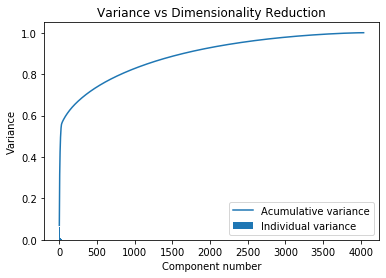

In [65]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [66]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.069829,0.069829
1,2.0,0.069047,0.138876
2,3.0,0.059549,0.198425
3,4.0,0.041773,0.240198
4,5.0,0.040349,0.280547


We´ve decided to keep the 95% of the variability in the original data, so we are going to reduce the dataframe to 2360 dimensions (the initial variables where 4038)

In [67]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.95:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Using 2360 variables, we can explain 0.95 of the variability in the original data.


In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 2360)
movies_pca = pca.fit_transform(movies2)

In [69]:
movies_pca_end = pd.DataFrame(movies_pca)
movies_pca_end.head()

,0,1,2,3,4,5,6,7,8,9,...,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359
0,-0.313689,-0.597162,0.128842,0.330291,-0.026077,-0.459146,-0.338470,0.265075,0.117596,-0.198416,...,0.002364,0.004838,-0.001615,0.002401,-0.012468,-0.001802,-0.001164,-0.001745,-0.001856,0.000547
1,-0.298847,-0.574206,0.121152,0.325026,-0.009466,-0.413827,-0.327309,0.247606,0.100154,-0.166438,...,0.002250,0.006698,-0.000252,0.004020,-0.012722,-0.000143,-0.002631,0.000178,-0.000795,0.000714
2,-0.146172,-0.806537,-0.139703,0.250200,0.049599,-0.459049,0.495977,0.532852,0.007198,0.204848,...,0.003879,0.006271,0.000197,0.006699,-0.012567,-0.000628,-0.002414,-0.000456,-0.000014,0.003899
3,0.092787,0.304939,0.404004,0.212250,1.086380,-0.414995,-0.356969,0.261278,-0.799672,0.261945,...,0.004386,-0.000465,0.003043,0.000428,-0.001795,0.003828,-0.003754,0.000948,0.000681,-0.001532
4,0.178087,0.279010,0.277412,0.245441,0.854464,-0.480230,-0.298539,0.343962,-0.627673,-0.015954,...,-0.003278,0.002029,-0.001147,0.002163,0.006695,-0.002591,0.002271,0.004459,0.004102,0.007186


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [70]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [71]:
# Get weights for the first principal component
pc_indexes(movies2, pca, 1)

genre_Comedy       0.5640
dec__2010         -0.5134
genre_Drama       -0.4305
dec__2000          0.3448
genre_Thriller    -0.1734
genre_Adventure    0.1203
genre_Romance      0.1040
dec__1990          0.0960
genre_Crime       -0.0947
genre_Mystery     -0.0900
Name: Dimension 1, dtype: float64

In [72]:
pc_indexes(movies2, pca, 2)

genre_Drama       -0.6524
genre_Action       0.4012
dec__2010          0.3545
genre_Adventure    0.2836
genre_Romance     -0.2707
dec__2000         -0.2509
genre_Thriller     0.1360
genre_Horror       0.1182
genre_Sci-Fi       0.0960
Year               0.0685
Name: Dimension 2, dtype: float64

In [73]:
pc_indexes(movies2, pca, 3)

genre_Comedy     -0.5426
dec__2010        -0.4686
dec__2000         0.4239
genre_Action      0.2726
genre_Thriller    0.2673
genre_Romance    -0.2493
genre_Crime       0.2326
genre_Horror      0.1100
genre_Mystery     0.1093
genre_Drama      -0.0629
Name: Dimension 3, dtype: float64

In [74]:
pc_indexes(movies2, pca, 4)

dec__2000       -0.6124
dec__1990        0.6005
dec__2010       -0.3431
genre_Crime      0.2245
Year            -0.2009
dec__1980        0.1568
genre_Romance   -0.0750
dec__1970        0.0679
genre_Horror    -0.0543
dec__1960        0.0472
Name: Dimension 4, dtype: float64

We can see that the first 4 principal components are based on the genre and when it was filmed (different decades or year)

#### Merging dataframes

In [75]:
movies_pca_end

,0,1,2,3,4,5,6,7,8,9,...,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359
0,-0.313689,-0.597162,0.128842,0.330291,-0.026077,-0.459146,-0.338470,0.265075,0.117596,-0.198416,...,0.002364,0.004838,-0.001615,0.002401,-0.012468,-0.001802,-0.001164,-0.001745,-0.001856,0.000547
1,-0.298847,-0.574206,0.121152,0.325026,-0.009466,-0.413827,-0.327309,0.247606,0.100154,-0.166438,...,0.002250,0.006698,-0.000252,0.004020,-0.012722,-0.000143,-0.002631,0.000178,-0.000795,0.000714
2,-0.146172,-0.806537,-0.139703,0.250200,0.049599,-0.459049,0.495977,0.532852,0.007198,0.204848,...,0.003879,0.006271,0.000197,0.006699,-0.012567,-0.000628,-0.002414,-0.000456,-0.000014,0.003899
3,0.092787,0.304939,0.404004,0.212250,1.086380,-0.414995,-0.356969,0.261278,-0.799672,0.261945,...,0.004386,-0.000465,0.003043,0.000428,-0.001795,0.003828,-0.003754,0.000948,0.000681,-0.001532
4,0.178087,0.279010,0.277412,0.245441,0.854464,-0.480230,-0.298539,0.343962,-0.627673,-0.015954,...,-0.003278,0.002029,-0.001147,0.002163,0.006695,-0.002591,0.002271,0.004459,0.004102,0.007186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11061,0.779257,-0.054088,-0.666233,0.032057,0.255374,0.048129,0.570094,0.317912,-0.015818,0.155142,...,-0.000648,0.000673,0.001479,-0.005310,0.002933,-0.001812,0.000180,-0.001075,0.004129,0.000620
11062,-0.740066,0.008587,-0.423146,-0.273674,-0.088458,-0.305347,-0.349565,-0.191655,-0.116923,0.184301,...,0.004292,-0.002037,0.005459,0.002902,-0.001262,-0.018424,-0.009953,-0.018614,-0.008223,0.009463
11063,0.267366,0.297247,-1.137719,-0.311929,0.213045,0.210269,0.619867,0.195659,-0.071977,0.221898,...,0.035844,-0.014355,-0.022498,-0.004909,0.001140,-0.027466,0.003385,-0.001770,0.015715,-0.006672
11064,0.648093,0.615286,-0.151195,0.150485,-0.288017,0.149552,0.142450,0.122085,-0.093968,-0.615604,...,0.026943,-0.016551,-0.005547,-0.006136,-0.013362,-0.001087,-0.010360,0.004860,0.028285,-0.005910


In [76]:
movies1

,averageRating
0,0.638554
1,0.819277
2,0.759036
3,0.855422
4,0.746988
...,...
11061,0.722892
11062,0.795181
11063,0.554217
11064,0.493976


In [77]:
df_movies = pd.merge(movies1, movies_pca_end, left_index=True, right_index=True)

In [78]:
df_movies.head()

,averageRating,0,1,2,3,4,5,6,7,8,...,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359
0,0.638554,-0.313689,-0.597162,0.128842,0.330291,-0.026077,-0.459146,-0.338470,0.265075,0.117596,...,0.002364,0.004838,-0.001615,0.002401,-0.012468,-0.001802,-0.001164,-0.001745,-0.001856,0.000547
1,0.819277,-0.298847,-0.574206,0.121152,0.325026,-0.009466,-0.413827,-0.327309,0.247606,0.100154,...,0.002250,0.006698,-0.000252,0.004020,-0.012722,-0.000143,-0.002631,0.000178,-0.000795,0.000714
2,0.759036,-0.146172,-0.806537,-0.139703,0.250200,0.049599,-0.459049,0.495977,0.532852,0.007198,...,0.003879,0.006271,0.000197,0.006699,-0.012567,-0.000628,-0.002414,-0.000456,-0.000014,0.003899
3,0.855422,0.092787,0.304939,0.404004,0.212250,1.086380,-0.414995,-0.356969,0.261278,-0.799672,...,0.004386,-0.000465,0.003043,0.000428,-0.001795,0.003828,-0.003754,0.000948,0.000681,-0.001532
4,0.746988,0.178087,0.279010,0.277412,0.245441,0.854464,-0.480230,-0.298539,0.343962,-0.627673,...,-0.003278,0.002029,-0.001147,0.002163,0.006695,-0.002591,0.002271,0.004459,0.004102,0.007186


### <a class="anchor" id="Alg_Selection"> 2.b.- Algorithm Selection
We´re going to test a few regression algorithms with all the features and the default parameters to see which one works better

In [79]:
X = df_movies.drop("averageRating", axis=1).copy()
y = df_movies["averageRating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8852, 2360), (8852,), (2214, 2360), (2214,))

In [80]:
#function to test the algorithm
def test_model(alg):
    train_score = 0
    test_score = 0
    clf = alg
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test) 
    
    return train_score, test_score

In [81]:
#Test Linear Regression, create df of scores and its score
model = test_model(LinearRegression())
scores = pd.DataFrame({'Algorithm': 'Linear Regression', 'Train_score': [model[0]], 'Test_score': [model[1]]},columns = ['Algorithm','Train_score','Test_score'])

In [83]:
#Test Lasso, create add score to df
model =test_model(Lasso())
scores = scores.append({'Algorithm' : 'Lasso' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [85]:
#Test Elastic Net, create add score to df
model =test_model(ElasticNet())
scores = scores.append({'Algorithm' : 'Elastic Net' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)


In [87]:
#Test KNeighborsRegressor(), create add score to df
model =test_model(KNeighborsRegressor())
scores = scores.append({'Algorithm' :'KNeighbors Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [89]:
#Test DecisionTreeRegressor(), create add score to df
model =test_model(DecisionTreeRegressor())
scores = scores.append({'Algorithm' : 'Decision Tree Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [91]:
#Test GradientBoostingRegressor(), create add score to df
model =test_model(GradientBoostingRegressor())
scores = scores.append({'Algorithm' : 'Gradient Boosting Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [92]:
print("The score of the different algorithms is")
scores.sort_values(by ='Test_score', ascending = True)

The score of the different algorithms is


,Algorithm,Train_score,Test_score
4,Decision Tree Regressor,1.000000,-0.314014
1,Lasso,0.000000,-0.001798
2,Elastic Net,0.000000,-0.001798
3,KNeighbors Regressor,0.428934,0.184156
0,Linear Regression,0.645531,0.399437
5,Gradient Boosting Regressor,0.573026,0.491279


We are using R2 score:

- There are negative values in test score. This is because because the model can be arbitrarily worse, and it´s not a good model for this case (Decision Tree, Lasso and Elastic Net)

- Look at the Decision Tree...thats overfitting!!!! Almost one in train and negative in test.

- The two best are Linear Regression and Gradient Boosting Regressor, with similar results, around 0.4 score

This is a really poor prediction, telling us that is very difficult to predict wether or not people is going to like a movie or not. The next step should be tuning with parameters but it has not much sense with these poor results.

But the results of the prediction with Gradient Boosting Regressors are better here (movies with more than 10.000 votes) that in the previous case (movies with more than 100 votes

One possible reason for this poor results is the variety of movies, and depending on different things people like them or not. People don´t like the same way comedies than dramas, or even classical comedies than modern commedies.

In the next example we are going to try to predict the rating for commedies in 2010´s decade. Let´s see what happens